In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize(project='ee-urbanfootprint')
wroclaw = ee.Geometry.Point([17.0385, 51.1079]).buffer(25_000)   # 25km buffer


In [3]:
def corine_urban_fabric(aoi):
    clc = ee.Image("COPERNICUS/CORINE/V20/100m/2018").select("landcover").clip(aoi)
    urban = clc.eq(111).Or(clc.eq(112)).rename("urban_fabric")
    return urban

urban2018 = corine_urban_fabric(wroclaw)


In [4]:
def emb_year(year, aoi):
    col = (ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
           .filterDate(f"{year}-01-01", f"{year+1}-01-01")
           .filterBounds(aoi))
    return col.mosaic().clip(aoi)


In [5]:
K = 12

emb2018 = emb_year(2018, wroclaw)

# Sample points (use 100 m scale to reduce mismatch with CORINE 100 m)
samples = emb2018.sample(
    region=wroclaw,
    scale=100,
    numPixels=12000,
    seed=42,
    geometries=False
)

clusterer = ee.Clusterer.wekaKMeans(K).train(samples)


In [6]:
def cluster_map(year):
    emb = emb_year(year, wroclaw)
    return emb.cluster(clusterer).rename("cluster")

def cluster_urban_score(cluster_img, urban_mask, aoi):
    """
    Returns dict: cluster_id -> fraction of pixels that are CORINE urban fabric
    """

    # IMPORTANT: band order must be [value_to_reduce, group_band]
    # value band index = 0, group band index = 1
    stacked = urban_mask.rename("urban").addBands(cluster_img.rename("cluster"))

    stats = stacked.reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName="cluster"),
        geometry=aoi,
        scale=100,
        maxPixels=1e13
    )

    groups = ee.List(stats.get("groups")).getInfo()

    out = {}
    for g in groups:
        out[int(g["cluster"])] = float(g["mean"])  # fraction urban in that cluster

    return out

cl2018 = cluster_map(2018)
urban_scores = cluster_urban_score(cl2018, urban2018, wroclaw)
urban_scores


{0: 0.00760869129416276,
 1: 0.13801807629865073,
 2: 0.005145940979062902,
 3: 0.6841595322865649,
 4: 0.005371938648755845,
 5: 0.01943405787962024,
 6: 0.0019022078665619831,
 7: 0.007794798438805243,
 8: 0.0037043906777928376,
 9: 0.39670778697807246,
 10: 0.04291247674711529,
 11: 0.6919927924657809}

In [7]:
URBAN_T = 0.60
NONURBAN_T = 0.20

urban_clusters = [c for c,s in urban_scores.items() if s >= URBAN_T]
nonurban_clusters = [c for c,s in urban_scores.items() if s <= NONURBAN_T]

urban_clusters, nonurban_clusters


([3, 11], [0, 1, 2, 4, 5, 6, 7, 8, 10])

In [8]:
def three_class_from_clusters(cluster_img):
    # 2 = urban, 0 = non-urban, 1 = uncertain
    urban = cluster_img.remap(urban_clusters, [1]*len(urban_clusters), 0)
    nonurban = cluster_img.remap(nonurban_clusters, [1]*len(nonurban_clusters), 0)

    uncertain = urban.Not().And(nonurban.Not())

    cls = nonurban.multiply(0).add(uncertain.multiply(1)).add(urban.multiply(2)).rename("cls")
    return cls


In [9]:
def area_km2(mask, aoi, scale=10):
    pix_area = ee.Image.pixelArea().divide(1e6)  # km²
    area_img = pix_area.updateMask(mask)
    s = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e13
    )
    v = s.get("area")
    return float(v.getInfo()) if v else 0.0

years = list(range(2018, 2025))
rows = []

for y in years:
    cl = cluster_map(y)
    cls = three_class_from_clusters(cl)

    # urban mask = class==2
    urban_mask = cls.eq(2).rename("area")
    urban_km2 = area_km2(urban_mask, wroclaw, scale=10)

    rows.append({"year": y, "urban_km2": urban_km2})

df = pd.DataFrame(rows)
df


,year,urban_km2
0,2018,192.792202
1,2019,212.035936
2,2020,220.960672
3,2021,232.402032
4,2022,231.228948
5,2023,234.424177
6,2024,232.815214


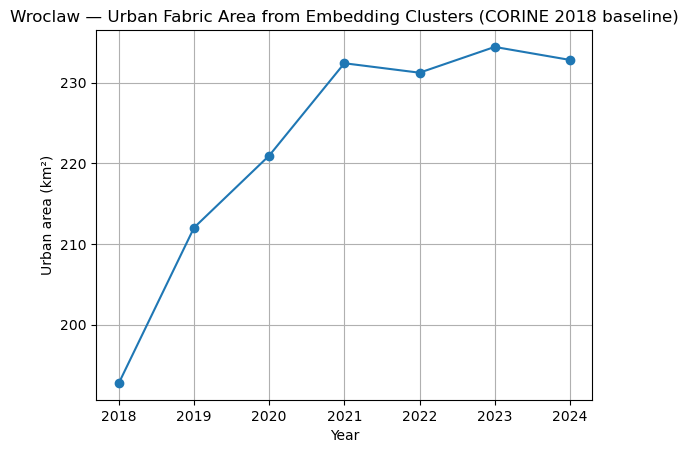

In [10]:
plt.figure()
plt.plot(df["year"], df["urban_km2"], marker="o")
plt.xlabel("Year")
plt.ylabel("Urban area (km²)")
plt.title("Wroclaw — Urban Fabric Area from Embedding Clusters (CORINE 2018 baseline)")
plt.grid(True)
plt.show()


In [11]:
cls_2018 = three_class_from_clusters(cluster_map(2018))
cls_2024 = three_class_from_clusters(cluster_map(2024))

urban18 = cls_2018.eq(2)
urban24 = cls_2024.eq(2)
uncertain = cls_2018.eq(1).Or(cls_2024.eq(1))

gain = urban18.Not().And(urban24)
loss = urban18.And(urban24.Not())

# change classes:
# 0 = no change, 1 = gain, 2 = loss, 3 = uncertain
change = (gain.multiply(1)
          .add(loss.multiply(2))
          .add(uncertain.multiply(3))).rename("change")


In [12]:
m = geemap.Map()
m.centerObject(wroclaw, 9)

m.addLayer(change, {"min": 0, "max": 3, "palette": ["000000", "00ff00", "ff0000", "ffff00"]},
           "Change 2018→2024 (gain/loss/uncertain)")

m


Map(center=[51.10792564696231, 17.03850113278467], controls=(WidgetControl(options=['position', 'transparent_b…

In [13]:
import numpy as np

# predicted urban for 2018 from clusters
pred2018 = three_class_from_clusters(cluster_map(2018))
pred_urban2018 = pred2018.eq(2).rename("pred")
gt_urban2018 = urban2018.rename("gt")

# sample for validation at 100m
val = pred_urban2018.addBands(gt_urban2018).sample(
    region=wroclaw, scale=100, numPixels=5000, seed=0, geometries=False
)

arr = np.array(val.aggregate_array("pred").getInfo())
gt  = np.array(val.aggregate_array("gt").getInfo())

TP = np.sum((arr==1) & (gt==1))
FP = np.sum((arr==1) & (gt==0))
FN = np.sum((arr==0) & (gt==1))
TN = np.sum((arr==0) & (gt==0))

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1        = 2*precision*recall/(precision+recall+1e-9)
iou       = TP / (TP + FP + FN + 1e-9)

print("TP FP FN TN:", TP, FP, FN, TN)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("IoU:", iou)


TP FP FN TN: 309 161 323 4207
Precision: 0.6574468085092395
Recall: 0.4889240506321378
F1: 0.5607985476041614
IoU: 0.3896595208065704


In [14]:
df["delta_km2"] = df["urban_km2"].diff()
df["pct_change"] = 100 * df["delta_km2"] / df["urban_km2"].shift(1)
df


,year,urban_km2,delta_km2,pct_change
0,2018,192.792202,NaN,NaN
1,2019,212.035936,19.243734,9.981594
2,2020,220.960672,8.924736,4.209067
3,2021,232.402032,11.441361,5.178008
4,2022,231.228948,-1.173084,-0.504765
5,2023,234.424177,3.195229,1.381846
6,2024,232.815214,-1.608963,-0.686347


In [15]:
total_gain = df["urban_km2"].iloc[-1] - df["urban_km2"].iloc[0]
print("Total urban increase 2018→2024 (km²):", total_gain)


Total urban increase 2018→2024 (km²): 40.02301219088824


In [16]:
def flip_rate(y0, y1):
    c0 = cluster_map(y0)
    c1 = cluster_map(y1)
    # where cluster changed
    changed = c0.neq(c1).rename("changed")
    # compute fraction changed (mean of changed mask)
    frac = changed.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=wroclaw,
        scale=100,
        maxPixels=1e13
    ).get("changed").getInfo()
    return frac

for y in range(2018, 2024):
    print(y, "→", y+1, "flip rate:", flip_rate(y, y+1))


2018 → 2019 flip rate: 0.4339467191519031
2019 → 2020 flip rate: 0.4191201964336626
2020 → 2021 flip rate: 0.42123737383842214
2021 → 2022 flip rate: 0.4024015444696022
2022 → 2023 flip rate: 0.40812796401417606
2023 → 2024 flip rate: 0.4235378745718428


In [17]:
years = list(range(2018, 2025))  # 2018..2024
clusters = [cluster_map(y) for y in years]

# count how many times cluster label changes year-to-year
flip_imgs = []
for i in range(len(clusters) - 1):
    flip_imgs.append(clusters[i].neq(clusters[i+1]).rename("flip"))

instability = ee.ImageCollection(flip_imgs).sum().rename("n_flips")


In [18]:
m = geemap.Map()
m.centerObject(wroclaw, 9)

vis = {
    "min": 0,
    "max": 6,
    "palette": ["1a1a1a", "ffffb2", "fecc5c", "fd8d3c", "f03b20", "bd0026"]
}

m.addLayer(instability, vis, "Embedding instability (2018–2024)")
m


Map(center=[51.10792564696231, 17.03850113278467], controls=(WidgetControl(options=['position', 'transparent_b…

In [19]:
cls2018 = three_class_from_clusters(cluster_map(2018))
urban_edge = cls2018.eq(2).focal_max(1).neq(cls2018.eq(2)).selfMask()

m = geemap.Map()
m.centerObject(wroclaw, 9)
m.addLayer(instability, vis, "Instability")
m.addLayer(urban_edge, {"palette": ["00ffff"]}, "Urban edge (2018)")
m


Map(center=[51.10792564696231, 17.03850113278467], controls=(WidgetControl(options=['position', 'transparent_b…

In [20]:
def mean_instability(mask):
    return instability.updateMask(mask).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=wroclaw,
        scale=100,
        maxPixels=1e13
    ).get("n_flips").getInfo()

urban_mask = cls2018.eq(2)
nonurban_mask = cls2018.eq(0)
uncertain_mask = cls2018.eq(1)

print("Mean flips in urban:", mean_instability(urban_mask))
print("Mean flips in non-urban:", mean_instability(nonurban_mask))
print("Mean flips in uncertain:", mean_instability(uncertain_mask))


Mean flips in urban: 0.3617335106564221
Mean flips in non-urban: 2.9310464570843533
Mean flips in uncertain: 0.8917529066840149


In [21]:
# make transparent where 0
change_vis = {"min": 0, "max": 3, "palette": ["00000000","00ff00","ff0000","ffff00"]}

m = geemap.Map()
m.centerObject(wroclaw, 9)
m.addLayer(change.updateMask(change.neq(0)), change_vis, "Urban change 2018→2024")
m


Map(center=[51.10792564696231, 17.03850113278467], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
cls2018 = three_class_from_clusters(cluster_map(2018))
cls2024 = three_class_from_clusters(cluster_map(2024))

palette = ["0000ff", "aaaaaa", "ff0000"]  # nonurban / uncertain / urban

m = geemap.Map()
m.centerObject(wroclaw, 9)
m.addLayer(cls2018, {"min":0,"max":2,"palette":palette}, "3-class 2018")
m.addLayer(cls2024, {"min":0,"max":2,"palette":palette}, "3-class 2024")
m


Map(center=[52.229725646962365, 21.012201161188926], controls=(WidgetControl(options=['position', 'transparent…